## Throid segmentation - Grand challenges

https://tn-scui2020.grand-challenge.org/Source_links/


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [0]:
!pip uninstall torch torchvision -y
!pip install torch==1.4.0 torchvision==0.5.0

## Import dataset from Kaggle 

In [0]:
#https://www.kaggle.com/amritpal333/throid-segmentation?


In [0]:
!pip install kaggle
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
#!kaggle datasets download -d amritpal333/throid-segmentation

!kaggle datasets download -d amritpal333/thyroid-segmentation-same-name

In [0]:
!unzip -qq '/content/thyroid-segmentation-same-name.zip'

#!unzip -qq '/content/throid-segmentation.zip'  -d '/' #takes 15 minutes
#https://askubuntu.com/questions/458931/unpack-a-war-file-to-a-destination-folder-without-verbose-output

## Chest Xray masks
https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels


In [0]:
# !kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels

 49% 4.73G/9.58G [03:51<07:09, 12.1MB/s]User cancelled operation


## Subset classes 子集类

In [0]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data 数据

In [0]:
path_img = '/content/00000TNSCUI2020_train/TNSCUI2020_train/image'
path_lbl = '/content/00000TNSCUI2020_train/TNSCUI2020_train/mask'

In [0]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/content/00000TNSCUI2020_train/TNSCUI2020_train/image/9252.PNG'),
 PosixPath('/content/00000TNSCUI2020_train/TNSCUI2020_train/image/7996.PNG'),
 PosixPath('/content/00000TNSCUI2020_train/TNSCUI2020_train/image/380.PNG')]

In [0]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/content/00000TNSCUI2020_train/TNSCUI2020_train/mask/9252.PNG'),
 PosixPath('/content/00000TNSCUI2020_train/TNSCUI2020_train/mask/7996.PNG'),
 PosixPath('/content/00000TNSCUI2020_train/TNSCUI2020_train/mask/380.PNG')]

In [0]:
fnames[1]

PosixPath('/content/00000TNSCUI2020_train/TNSCUI2020_train/image/7996.PNG')

In [0]:
lbl_names[1]

PosixPath('/content/00000TNSCUI2020_train/TNSCUI2020_train/mask/7996.PNG')

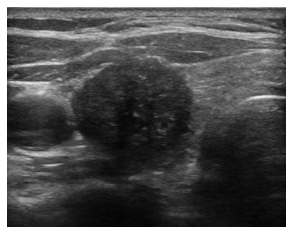

In [0]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
from pathlib import Path
import os

In [0]:
def get_y_fn(filename):
   b = Path(path_lbl).joinpath(Path(filename).name)
   return b

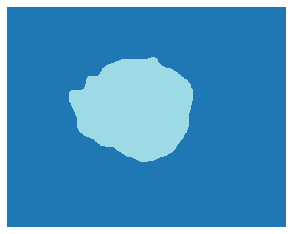

In [0]:
mask = open_mask(get_y_fn(fnames[0]))
mask.show(figsize=(5,5), alpha=1)

In [0]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([600, 760]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [0]:
codes = np.loadtxt('/content/codes.txt', dtype=str); codes

array(['thyroid', 'other'], dtype='<U7')

## Datasets 数据集

In [0]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7601MB of GPU RAM free


In [0]:
bs =2

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('/content/valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
data.show_batch(2, figsize=(10,7))

RuntimeError: ignored

In [0]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

RuntimeError: ignored

## Model 模型

In [0]:
metrics=accuracy

In [0]:
CUDA_LAUNCH_BLOCKING=1

In [0]:
wd=1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

RuntimeError: ignored

In [0]:
lr_find(learn)
learn.recorder.plot()

RuntimeError: ignored

In [0]:
lr=3e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

KeyboardInterrupt: ignored

In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

In [0]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [0]:
learn.save('stage-2');

## Go big 用更大的数据集进行训练

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.<br>
如果内存不够的话，你可能需要重启你的计算内核，然后再返回这一步，同时可能要减少 `bs` 的设定。

In [0]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

In [0]:
learn.show_results(rows=3, figsize=(10,10))